In [ ]:
%load_ext autoreload
%autoreload 2

import wikipedia # used for search of terms, provides: DisambiguationError

import wikipediaapi # used because can get categorymembers in a given category
wiki_wiki = wikipediaapi.Wikipedia('en')
# Might be able to use pywikibot for everything, or at least more
# https://stackoverflow.com/questions/71023854/how-to-find-subcategories-and-subpages-on-wikipedia-using-pywikibot
import pywikibot as pw # used to get AND filter hidden categories for an article

import graphviz

import stanza
stanza.download('en') # download English model

!jupyter nbextension install --py widgetsnbextension
!jupyter nbextension enable --py widgetsnbextension

nlp = stanza.Pipeline(lang='en', processors='tokenize,lemma,pos,depparse')

# https://www.sbert.net/docs/pretrained_models.html
from sentence_transformers import SentenceTransformer, util
#model = SentenceTransformer('all-MiniLM-L12-v2')
model = SentenceTransformer('all-MiniLM-L6-v2')

import numpy as np
import pickle

import datetime as dt

import re
import requests
import time
from collections import Counter
from os.path import exists as file_exists
 

2022-04-24 18:06:40 INFO: Downloading default packages for language: en (English)...
2022-04-24 18:06:46 INFO: File exists: /root/stanza_resources/en/default.zip
2022-04-24 18:07:00 INFO: Finished downloading models and saved to /root/stanza_resources.
Installing /root/venv/lib/python3.7/site-packages/widgetsnbextension/static -> jupyter-js-widgets
Up to date: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js
Up to date: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.map
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --py
    
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/deepnote-config/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/deepnote-config/jup

2022-04-24 18:07:06 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2022-04-24 18:07:07 INFO: Use device: cpu
2022-04-24 18:07:07 INFO: Loading: tokenize
2022-04-24 18:07:07 INFO: Loading: pos
2022-04-24 18:07:07 INFO: Loading: lemma
2022-04-24 18:07:07 INFO: Loading: depparse
2022-04-24 18:07:08 INFO: Done loading processors!


In [ ]:
def get_categories_from_wiki_article(article):
    """Gets all the non-meta or non-hidden categories for a Wikipedia article

    Parameters
    ----------
    article : str
        The title of the Wikipedia article: 'Squid Game'

    Returns
    -------
    list
        a list of categories that the article belongs to
    """


    # use pywikibot because it can filter hidden 'meta' categories that aren't needed
    # https://stackoverflow.com/questions/54526821/how-to-identify-wikipedia-categories-in-python
    site = pw.Site("en", "wikipedia")
    non_hidden = [
        cat.title()[:]
        for cat in pw.Page(site, article).categories()
        if 'hidden' not in cat.categoryinfo
    ]
    
    return(non_hidden)

#get_categories_from_wiki_article('Squid Game')

In [ ]:
def get_best_categories_for_term(wiki_term, wiki_cats, nlp_cat_phrase):
    """Filters all the Wikipedia categories to those that are closest by cosine similarity to
    NLP category

    Parameters
    ----------
    wiki_term : str
        The title of the Wikipedia article: 'Squid Game'

    wiki_cats : list
        List of Wikipedia categories to filter

    nlp_cat_phrase: str
        The found NLP category from the first sentence of the article
    
    Returns
    -------
    list
        a list of filtered categories that the article belongs to
    """



    # remove parens and anyting inside them
    wiki_term = re.sub(r'\([^)]*\)', '', wiki_term)
    print('wiki_cats:', wiki_cats)
    print('')

    # https://stackoverflow.com/questions/65199011/is-there-a-way-to-check-similarity-between-two-full-sentences-in-python
    rem_term_cats = [' '.join([wiki_term])] + wiki_cats
    rem_first = model.encode(rem_term_cats)

    print("Remove wiki-cats too close to actual term(first term)")
    print(rem_term_cats)
    cos_remove = util.pytorch_cos_sim(rem_first, rem_first)[0].numpy()
    print(cos_remove)
    rem_idx = np.where(cos_remove > .7)[0]
    #because first item is our search term here, but we need to remove items from wiki_cats, so subtract 1
    rem_idx_from_wiki_cats = rem_idx[1:]-1
    print(rem_idx_from_wiki_cats)
    rem_too_close_wiki_cats = [j for i, j in enumerate(wiki_cats) if i not in rem_idx_from_wiki_cats]
    
    if len(rem_too_close_wiki_cats) != 0:
        print('could remove categories too close and have something left.')
        wiki_cats = rem_too_close_wiki_cats
    else:
        print('left removed cats or else none would be left')
    print('after rem:', wiki_cats)


    keep_cat_cats = [' '.join(nlp_cat_phrase)] + wiki_cats
    keep_first = model.encode(keep_cat_cats)

    print("Keep wiki-cats not too far to found category(first term)")
    print(keep_cat_cats)
    keep_cos = util.pytorch_cos_sim(keep_first, keep_first)[0].numpy()
    print(keep_cos)
    keep_idx = np.where(keep_cos > .7)[0]

    keep_idx_from_wiki_cats = keep_idx[1:]-1

    print('keep idx:', keep_idx_from_wiki_cats)
    print('pre-last-filt:', wiki_cats)

    # if we got anything with a decent score, keep those, otherwise everything
    
    if len(keep_idx_from_wiki_cats) >= 2:
        wiki_cats = [j for i, j in enumerate(wiki_cats) if i in keep_idx_from_wiki_cats]
    else:
        # keep Top 5 categories if filtering doesn't return much
        cats_cos = list(zip(keep_cat_cats, keep_cos))
        top_cats_cos = sorted(cats_cos, key=lambda x: x[1], reverse=True)[1:6]
        wiki_cats = [i[0] for i in top_cats_cos]



    print('post-last-filt:', wiki_cats)

    return wiki_cats

In [ ]:
def get_first_unambiguous_wiki_term_and_page(search_term):
    """Returns the first Wikipedia term that doesn't have a Disambiguation error

    Parameters
    ----------
    search_term : str
        Human entered search term

    
    Returns
    -------
    first_wiki_term
        The Wikipedia term of the first good article
    
    page
        Object containing page text
    """

    search_results = wikipedia.search(search_term)

    first_wiki_term = search_results[0]    
    #https://github.com/goldsmith/Wikipedia/issues/295
    try:
        page = wikipedia.page(first_wiki_term, auto_suggest=False)    
    except wikipedia.DisambiguationError:
        print("Oops! DisambiguationError, trying next result")
        first_wiki_term = search_results[1]
        page = wikipedia.page(first_wiki_term, auto_suggest=False)

    print('first_wiki_term:', first_wiki_term)
    return first_wiki_term, page

In [ ]:
def get_stanza_dict_of_first_sentence(wiki_summary_text):
    """Returns the parsed results of the first sentece of the input text, as parsed by Stanza

    Parameters
    ----------
    wiki_summary_text : str
        Any text, here it's the summary from Wikipedia, the text at the top of any page

    
    Returns
    -------
    doc.sentences[0].to_dict()
        Dict of results of senetce parsing
    
    """

    # Using stanza instead of nltk to save memory
    doc = nlp(wiki_summary_text)
    return doc.sentences[0].to_dict()
    #first_sentence.text

In [ ]:
#first_wiki_term, wiki_page = get_first_unambiguous_wiki_term_and_page('Gamestop short squeeze')
#graph_sent(get_stanza_dict_of_first_sentence(wiki_page.summary))

In [ ]:
def get_nlp_category_phrase(wiki_page):   
    """Returns the parsed results of the first sentece of the input text, as parsed by Stanza
    The input sentence generally needs to have a structure like:
    "The thing IS A so and so kind of object"

    Parameters
    ----------
    wiki_page : object
        The Wikipedia object containing the summary and page text, among other things

    
    Returns
    -------
    nlp_category_phrase : List
        List of words used to decribe the Thing on the Wikipedia page
    
    """

    
    wiki_page_text = wiki_page.summary
    # # Using stanza instead of nltk to save memory
    # doc = nlp(wiki_page_text)
    # first_sentence = doc.sentences[0]
    # #first_sentence.text
    sent_dict = get_stanza_dict_of_first_sentence(wiki_page_text)

    # Look for the ROOT word of the dependency tree
    # hopefully not the first word
    root_id = 0
    root_word = ''
    for word in sent_dict:
        if word['head'] == 0:
            root_id = word['id']
            root_word = word['text']
            break    

    # print("first root id:", root_id)
    # print("first root word:", root_word)            

    # Lost TV series for some reason has ROOT as first word
    if root_id in [1]:
        for word in sent_dict:
            if (word['head'] == 1) & (word['deprel'] in ['nsubj:pass', 'parataxis']):
                root_id = word['id']                
                root_word = word['text']
                break

    # print("new root id:", root_id)
    # print("new root word:", root_word)

    # Get all modifiers of ROOT word, loop up to 3 times to get enough words
    all_dep_ids = []

    for i in range(3):  # at most 3 loops
        cur_dep_ids = []
        for word in sent_dict:
            if ((word['head'] in all_dep_ids + [root_id]) & (word['deprel'] in ['obl', 'compound','amod','nmod','conj','appos'])):
                cur_dep_ids.append(word['id'])

        all_dep_ids.extend(cur_dep_ids)
        #print(i, all_dep_ids)
        if len(all_dep_ids) > 2:    # bring back at least 4 words, if we have more, then they're too far away
            break
    #print(all_dep_ids)
    all_dep_ids.append(root_id)

    category_phrase_dict = dict()
    for word in sent_dict:
        if (word['id'] in all_dep_ids):
            category_phrase_dict[word['id']] = word['text']

    #print(category_phrase_dict)

    nlp_category_phrase = []
    for k,v in category_phrase_dict.items():
        nlp_category_phrase.append(v)
    #print('**', search_term, '**', first_wiki_term, '**', nlp_category_phrase)
    #print(wiki_page.categories)

    # print(nlp_category_phrase)
    index_root_word = nlp_category_phrase.index(root_word)
    
    # this was an attempt to cut off the phrases at the root word, but some continue past it, iPhone for example
    #nlp_category_phrase = nlp_category_phrase[:index_root_word+1]

    print('nlp phrase:', nlp_category_phrase)
    return nlp_category_phrase


In [ ]:
def get_category_from_search_term(search_term, mvp_flag):   
    
    first_wiki_term, wiki_page = get_first_unambiguous_wiki_term_and_page(search_term)

    nlp_category_phrase = get_nlp_category_phrase(wiki_page)

    raw_wiki_cats = get_categories_from_wiki_article(first_wiki_term)

    best_wiki_cats = get_best_categories_for_term(first_wiki_term, raw_wiki_cats, nlp_category_phrase)

    expanded_year_wiki_cats = get_all_combined_wiki_cats(best_wiki_cats)

    make_white_list_cat_content_files(expanded_year_wiki_cats, first_wiki_term, mvp_flag)

    return nlp_category_phrase, expanded_year_wiki_cats, best_wiki_cats, first_wiki_term

In [ ]:
def get_wiki_wiki_pages_for_cat_members(category):
    wiki_cat = ''
    try:
        wiki_cat = wiki_wiki.page(category)        
    except requests.exceptions.SSLError:
        print("SSLError exception caught!!!!!!!!!!!!!!!")
        time.sleep(5)
        wiki_cat = wiki_wiki.page(category)
    return wiki_cat

In [ ]:
test_wiki_cat = "Category:Board games introduced in 1995"
def return_new_year_cats(wiki_cat):
    """Take an individual Wikipedia category and looks for mentioned years or decades
    ex 1998, 1990's
    The replaces them with the last 5 years and the currect decade, respectively
    ex 2018, 2019, 2020, 2021, 2022 and 2020's
    Then check to see which of those exist in Wikipedia

    Parameters
    ----------
    wiki_cat : str
        Wikipedia category
        ex: "Category:Board games introduced in 1995"

    
    Returns
    -------
    new_cat_list : List
        List of existing Wikipedia categories with current timeframes
    
    """


    year_pattern = re.compile('(19|20)\d{2}s?')
    check_for_year = re.search(year_pattern, wiki_cat)

    curr_year = dt.datetime.now().year

    new_cat_list = []

    if check_for_year != None:
        #print('found', check_for_year.group(0), 'in category:', wiki_cat)        
        found_year = check_for_year.group(0)

        if 's' in found_year:
            new_category = wiki_cat.replace(found_year, '2020s')
            print(new_category)
            #check category exists
            pages_in_new_cat = len(get_wiki_wiki_pages_for_cat_members(new_category).categorymembers.keys())
            if pages_in_new_cat > 0:
                # add cat to existing list
                #print(pages_in_new_cat, 'exists!')
                new_cat_list.append(new_category)
        else:
            for pot_year in [str(x) for x in [curr_year - i for i in range(5)]]:
                
                #print(pot_year)
                new_category = wiki_cat.replace(found_year, pot_year)
                #check category exists
                pages_in_new_cat = len(get_wiki_wiki_pages_for_cat_members(new_category).categorymembers.keys())
                if pages_in_new_cat > 0:
                    # add cat to existing list
                    #print(pages_in_new_cat, 'exists!')
                    new_cat_list.append(new_category)
                

    return new_cat_list

#return_new_year_cats(test_wiki_cat)


In [ ]:
def expand_years_in_cats_to_modern(list_wiki_cats):
    """Returns a list of Wikipedia categories, all of which have been checked to have recent years

    Parameters
    ----------
    list_wiki_cats : str
        Original list of Wikipedia category   
        
    Returns
    -------
    new_cat_list : List
        List of updated Wikipedia categories
    
    """

    new_year_cats_to_add = []
    # SSLError: HTTPSConnectionPool(host='en.wikipedia.org', port=443)

    for cat in list_wiki_cats:    
        #print("****", cat)
        try:
            new_year_cats_to_add.append(return_new_year_cats(cat))

        except requests.exceptions.SSLError:
            print("SSLError exception caught!!!!!!!!!!!!!!!")
            time.sleep(5)
            new_year_cats_to_add.append(return_new_year_cats(cat))   

    return new_year_cats_to_add



In [ ]:
def get_all_combined_wiki_cats(list_wiki_cats):
    combined_wiki_cats = list_wiki_cats
    for year_cats in expand_years_in_cats_to_modern(list_wiki_cats):
        combined_wiki_cats = list(set(combined_wiki_cats + year_cats))
    return combined_wiki_cats



In [ ]:
def make_cat_content_dict_from_cats(wiki_cats, wiki_term, mvp_flag, max_num_wiki_articles_per_cat = 200):
    """Makes dictionaries containing all of the Wikipedia text for up to 200 Wikipedia article per category

    Parameters
    ----------
    wiki_cats : list
        List of recent Wikipedia categories  
    wiki_term : str
        The Wikipedia term we're using
    mvp_flag: bool
        Whether or not to use precompiled pickle files of previopusly run results, if available

        
    Returns
    -------
    page_cat_content_dict : List
        List of list of dictionaries, by category
    
    """
    
    
    # given the filtered cats, try getting the summaries for all the pages mentioned into a dict, to pass to Kim
       
    page_cat_content_dict = dict()
    
    pkl_file_name = './output_step1/wiki_200_cat_content_' + wiki_term.replace(' ', '_') + '.pickle'

    if mvp_flag and file_exists(pkl_file_name):
        print('mvp! wikipedia cat content already exists.')
        with open(pkl_file_name, 'rb') as handle:
            page_cat_content_dict = pickle.load(handle)
    else:

        for idx, cat in enumerate(wiki_cats):
                
            page_content_dict = dict()

            try:       
                cat_page_member_keys = get_wiki_wiki_pages_for_cat_members(cat).categorymembers.keys()
            except requests.exceptions.SSLError:
                print("SSLError exception caught!!!!!!!!!!!!!!!")
                time.sleep(5)
                cat_page_member_keys = get_wiki_wiki_pages_for_cat_members(cat).categorymembers.keys()

            print(cat, idx+1, 'of', len(wiki_cats), ':', len(cat_page_member_keys))
            remove_from_pages = ['Category:', 'List of', 'Comparison of'] + [wiki_term]

            # list_of_filt_pages = [page for page in list(cat_page_member_keys)[:100] if not any(x.lower() in page.lower() for x in remove_from_pages)]
            list_of_filt_pages = [page for page in list(cat_page_member_keys) if not any(x.lower() in page.lower() for x in remove_from_pages)][:max_num_wiki_articles_per_cat]

            for filt_page in list_of_filt_pages:            
                try:                
                    page_content_dict[filt_page] = wikipedia.page(filt_page, auto_suggest=False).content                
                except wikipedia.DisambiguationError:
                    print("Oops! DisambiguationError, trying next result")                
                    continue
            
            page_cat_content_dict[cat] = page_content_dict

        print('Dumping wikipedia cat content file')
        with open(pkl_file_name, 'wb') as handle:
            pickle.dump(page_cat_content_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return page_cat_content_dict

    # need to catch timeout here, for hitting API too often



In [ ]:
#wiki_cats

In [ ]:
def get_whitelist_dicts_by_cat(wiki_cats, wiki_term):
    """Get whitelist of all Wikipedia article titles in each category
    Was to be used as first attempt to search unseen text

    Parameters
    ----------
    wiki_cats : list
        List of recent Wikipedia categories  
    wiki_term : str
        The Wikipedia term we're using
            
    Returns
    -------
    white_list_dict : List
        List of article titles
    
    """
    #print(wiki_cats)
    # to get whitelist of all terms to search for in sentences from Kim deemed to be related to our category
    white_list_dict = dict()
    for cat in wiki_cats:
        cat_page = get_wiki_wiki_pages_for_cat_members(cat)
        print(cat)#, len(cat_page.categorymembers.keys()))
        remove_from_pages = ['Category:', 'List of', 'Comparison of'] + [wiki_term]

        list_of_filt_pages = [page for page in cat_page.categorymembers.keys() if not any(x.lower() in page.lower() for x in remove_from_pages)]

        # get rid of everything between parens like this: 'Chimera (South Korean TV series)',
        # https://stackoverflow.com/questions/29570771/re-sub-on-lists-python-3
        # https://stackoverflow.com/questions/640001/how-can-i-remove-text-within-parentheses-with-a-regex
        # https://stackoverflow.com/questions/71023854/how-to-find-subcategories-and-subpages-on-wikipedia-using-pywikibot
        
        list_of_filt_pages_nothing_in_parens = [re.sub(r'\([^)]*\)', '', i) for i in list_of_filt_pages]

        list_of_filt_pages_no_parens = [i.replace('(', '').replace(')', '') for i in list_of_filt_pages]

        list_of_filt_pages_no_parens_strip = list(set([i.strip() for i in list_of_filt_pages_no_parens]))

        white_list_dict[cat] = list_of_filt_pages_no_parens_strip

    return white_list_dict



In [ ]:
def filter_whitelist_dict_for_common_words(white_list_dict, wiki_term):
    filt_white_list = dict()
    # remove words that are too common in each category
    # rule: appear at least 10 times, and be in greater than 20% of all entries

    for k, v in white_list_dict.items(): # {category:list of titles}
        print(len(v), k, v)
        words = Counter()
        for phrase in v:
            words.update(phrase.split())
        print(words)
        
        words_to_remove = []
        for word, count in words.most_common():
            if (count < 10):
                break
            if (count/len(v) > .2):
                words_to_remove.append(word)

        print("remove:", words_to_remove)

        p = re.compile('|'.join(map(re.escape, words_to_remove))) # escape to handle metachars
        filt_white_list[k] = [' '.join(p.sub('', s).split()) for s in v]

    return filt_white_list


In [ ]:
def make_white_list_cat_content_files(wiki_cats, wiki_term, mvp_flag):
    make_cat_content_dict_from_cats(wiki_cats, wiki_term, mvp_flag)
    
    white_list_dict = get_whitelist_dicts_by_cat(wiki_cats, wiki_term)
    white_list_dict

    filt_white_list = filter_whitelist_dict_for_common_words(white_list_dict, wiki_term)

    filt_white_list

    

    with open('./output_step1/white_list_200_' + wiki_term.replace(' ', '_') + '.pickle', 'wb') as handle:
        pickle.dump(filt_white_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print(wiki_term)

In [ ]:
test_terms = ['model t', 'squid game', 'lost tv', 'apple iphone', \
                'obama', 'trump', 'subway tile', 'sport', 'mandalorian',\
                'gamestop', 'ps5', 'bitcoin', 'ketogenic diet',\
                'dogecoin', 'ford bronco', 'ted lasso', 'pickle ball',\
                'data science', 'crocs', 'terraforming mars', 'final fantasy',\
                'catan', 'steve jobs', 'batman', 'tesla motors', 'cronut', 'cryptocurrency',\
                'elon musk', 'beastie boys', 'birkin bag', 'Game Stop Short Squeeze', 'oxycontin', \
                 'Virtual reality']

#term = 'Mother 3'
#mvp_flag = True

#nlp_cat_phrase, wiki_cats, init_wiki_cats, wiki_term = get_category_from_search_term(term, mvp_flag)
# # # Try search for all categories that are cosine close to search category

# make_white_list_cat_content_files(wiki_cats, wiki_term, mvp_flag)

['Pokémon', 'Pokémon (TV series)', 'Pokémon (video game series)', 'Pokémon Red and Blue', 'List of generation III Pokémon', 'List of generation I Pokémon', 'List of generation IV Pokémon', 'Pokémon Legends: Arceus', 'List of Pokémon', 'Gameplay of Pokémon']
Pokémon (an abbreviation for Pocket Monsters in Japan) is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996, and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport. All media works within the franchise are set in the Pokémon universe. The English slogan for the franchise is "Gotta Catch ‘Em All!". There are currently 908 Pokémon species.The franchise began as Pocket Monsters: Red and Green (later released outside of Japan as Pokémon Red and Blue), a pair of video games for the original Game Boy handheld system 

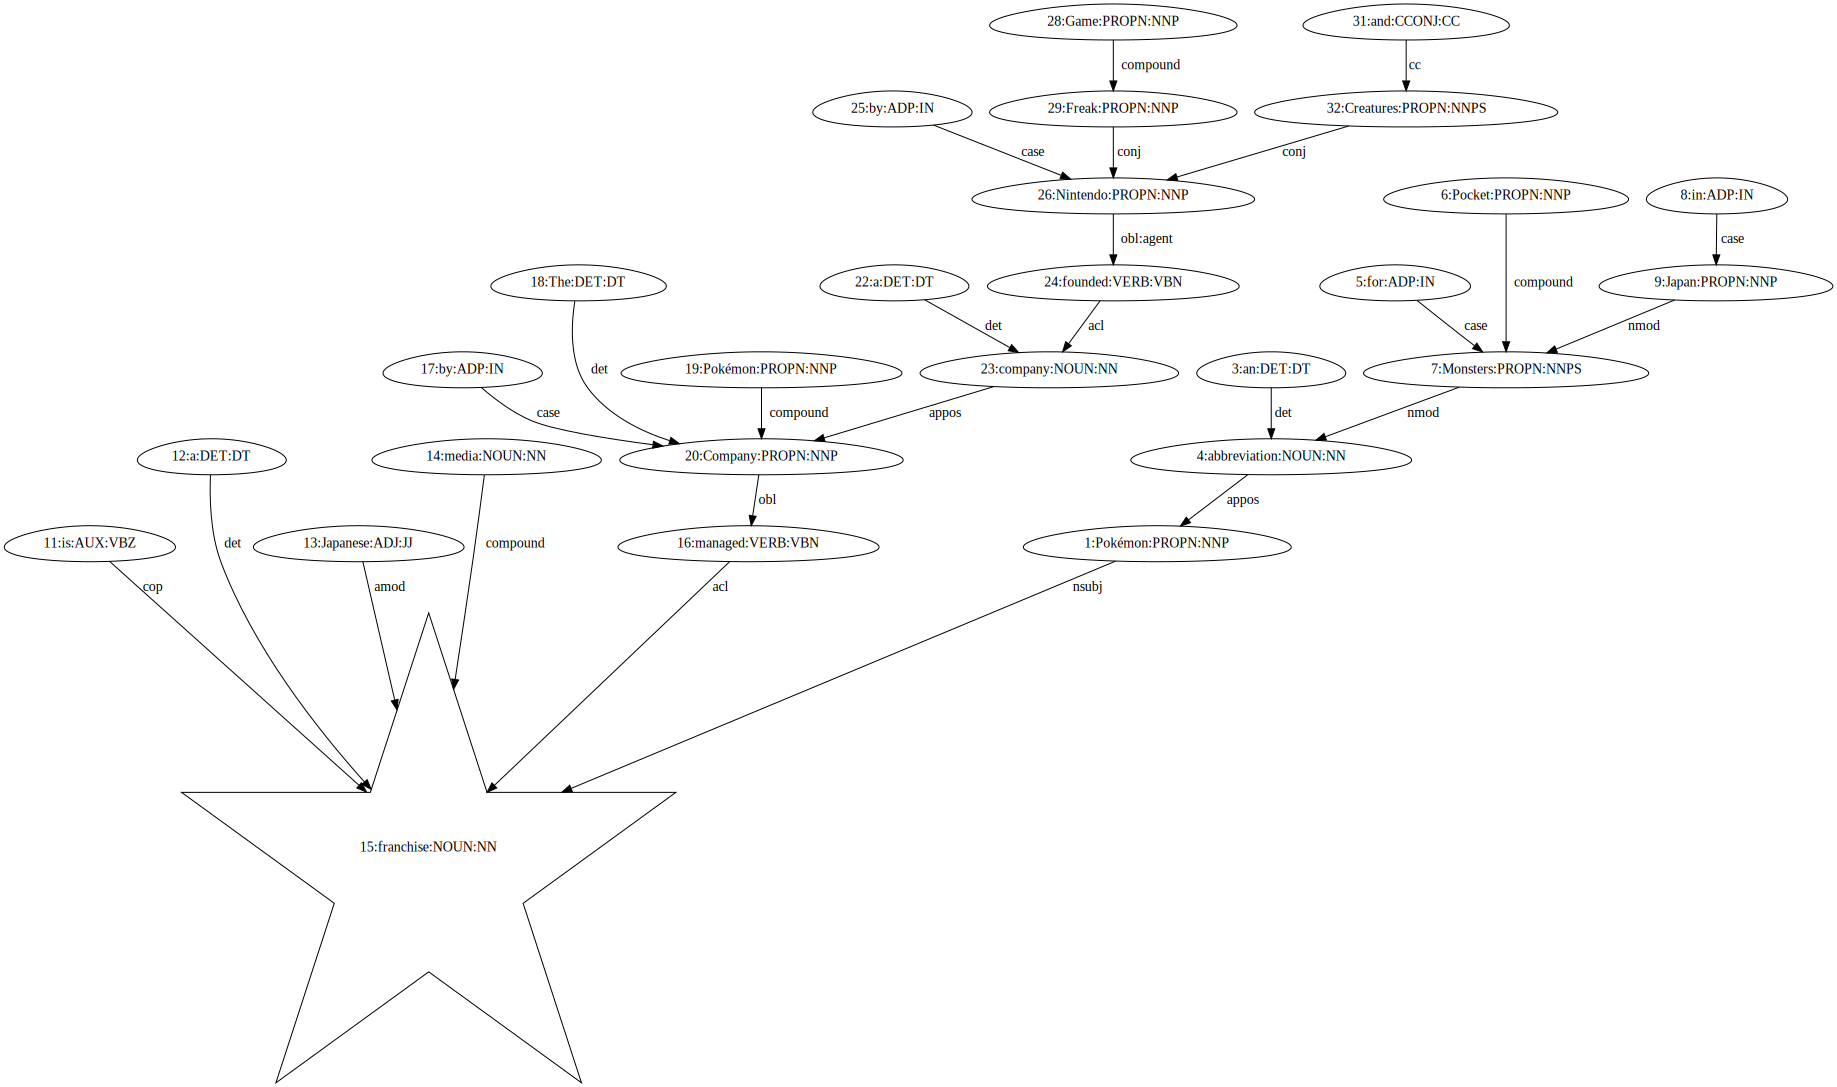

In [ ]:
def test_single_search_terms():
    # Just test code to see what each step is doing
    # Not needed to run, but to see individual parts of the process

    search_term = "Pokemon"

    search_results = wikipedia.search(search_term)
    print(search_results[:10])

    first_search_term = search_results[0]

    #https://github.com/goldsmith/Wikipedia/issues/295
    try:
        page = wikipedia.page(first_search_term, auto_suggest=False)    
    except wikipedia.DisambiguationError:
        print("Oops! DisambiguationError, trying next result")
        first_search_term = search_results[1]
        page = wikipedia.page(first_search_term, auto_suggest=False)

    # add gui for manual disambiguation
    print(page.summary)
    print(page.categories)

    
    # Using stanza instead of nltk to save memory
    doc = nlp(page.summary)
    first_sentence = doc.sentences[0]
    print(first_sentence.text)

    # print table of parts of speech
    # print ("{:<15} | {:<10} | {:<15} ".format('Token', 'Relation', 'Head'))
    # print ("-" * 50)
    
    # # Convert sentence object to dictionary  
    #sent_dict = doc.sentences[0].to_dict()
    sent_dict = first_sentence.to_dict()

    # iterate to print the token, relation and head
    for word in sent_dict:
      print ("{:<15} | {:<10} | {:<15} "
             .format(str(word['text']),str(word['deprel']),\
              str(sent_dict[word['head']-1]['text'] \
              if word['head'] > 0 else 'ROOT')))
    #print the dict structure
    print(sent_dict)

    # # Look for the ROOT word of the dependency tree
    # hopefully not the first wrod
    root_id = 0
    root_word = ''
    for word in sent_dict:
        if word['head'] == 0:
            root_id = word['id']
            root_word = word['text']
            break    

    print("first root id:", root_id)
    print("first root word:", root_word)

    # Lost TV series for some reason has ROOT as first word, so use what it's connected to as ROOT instead
    if root_id in [1]:
        for word in sent_dict:
            if (word['head'] == 1) & (word['deprel'] in ['nsubj:pass', 'parataxis']):
                root_id = word['id']
                root_word = word['text']
                break

    print("new root id:", root_id)
    print("new root word:", root_word)
    

    # Get all modifiers of ROOT word, loop up to 3 times to get enough words
    all_dep_ids = []

    for i in range(3): # at most 3 loops
        cur_dep_ids = []
        for word in sent_dict:
            if ((word['head'] in all_dep_ids + [root_id]) & (word['deprel'] in ['obl', 'compound','amod','nmod','conj','appos'])):
                cur_dep_ids.append(word['id'])

        all_dep_ids.extend(cur_dep_ids)
        print(i, all_dep_ids)
        if len(all_dep_ids) > 3: # bring back at least 3 words, if we have more, then they're too far away
            break
    print(all_dep_ids)
    all_dep_ids.append(root_id)

    category_phrase_dict = dict()
    for word in sent_dict:
        if (word['id'] in all_dep_ids):
            category_phrase_dict[word['id']] = (word['text'], word['deprel'])

    print(category_phrase_dict)

    category_phrase = []
    for k,v in category_phrase_dict.items():
        category_phrase.append(v[0])

    print('category_phrase:', category_phrase)
    index_root_word = category_phrase.index(root_word)
    category_phrase = category_phrase[:index_root_word+1]

    category_phrase

    # lop off everything after the root word - didn't work well, pros and cons

    

    id_word = {}
    root_id = 0
    for word in sent_dict:
        if word['upos'] != 'PUNCT':
            if word['head'] == 0:
                root_id = str(word['id']) 
            id_word[str(word['id'])] = str(word['id']) + ':' + word['text'] + ':' + word['upos'] + ':' + word['xpos']

    # Create Digraph object
    sent_tree = graphviz.Digraph('star_chart_' + search_term.replace(' ', '_'))

    # Add just the nodes from first traversal of dict
    for k, v in id_word.items(): 
        # Add nodes
        # https://graphviz.org/doc/info/shapes.html
        if k == root_id:
            sent_tree.node(k, v, shape='star')    
        else:
            sent_tree.node(k, v, shape='egg')


    # Traverse dict again to add all the relationships
    for word in sent_dict:
        if (word['upos'] != 'PUNCT') & (str(word['head']) != '0'):        
            sent_tree.edge(str(word['id']), str(word['head']), label=word['deprel'])

    #sent_tree.format = 'png'
    #sent_tree.render(directory='streamlit/images').replace('\\', '/')


    print(first_search_term)

    with open(first_search_term + '.txt', 'w') as f:
        f.write('Create a new text file!')

    # Visualize the graph
    return (sent_tree.unflatten(stagger=2))

#test_single_search_terms()

In [ ]:
# # https://pypi.org/project/Wikipedia-API/
# def print_categorymembers(categorymembers, level=0, max_level=1):
#         for c in categorymembers.values():
#             print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
#             if c.ns == wikipediaapi.Namespace.CATEGORY and level < max_level:
#                 print_categorymembers(c.categorymembers, level=level + 1, max_level=max_level)

In [ ]:
def simplify(text):
	import unicodedata
	try:
		text = unicode(text, 'utf-8')
	except NameError:
		pass
	text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
	return str(text)

#simplify('Pokémon')

'Pokemon'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90b052a7-f47d-474e-888f-9345355cfd9a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>